<a href="https://colab.research.google.com/github/mriduldewan/gpt/blob/main/1_Building_Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Credit : Andrej Karpathy

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # By default, we will assume that the gradient is 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        return out



In [12]:
# Simple example to show the forward pass

# Initialize the values
a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

# Just to check the labels in the class
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'

f = Value(-2.0, label='f')
l = d * f; l.label = 'l'
l

Value(data=-8.0)

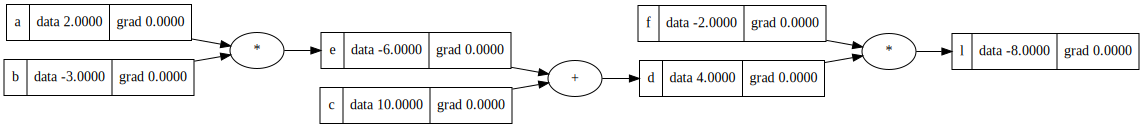

In [13]:
# Visualize the graph
from graphviz import Digraph

def trace(root):
    # Build a set of all notes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # For any value in the graph, create a rectangular ('record') node
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        # create a node for operation
        if n._op:
            dot.node(name=uid + n._op, label=n._op)

            # connect the operation node to the input nodes
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 and n2 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



draw_dot(l)

## Backpropagation

Essentially, what we are going to compute here is the derivative of each value wrt L (Loss function)

#### STEP 1

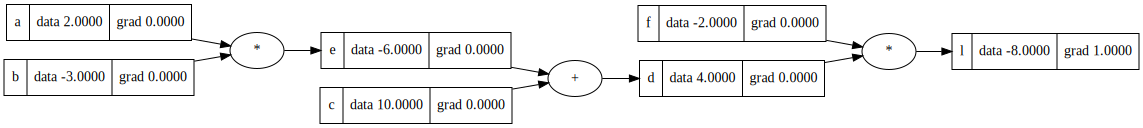

In [14]:
# Derivative of l wrt l is going to be 1 so we can just set it to 1
l.grad = 1.0

# Lets redraw the notes and see if it populates the gradient for l
draw_dot(l)

#### STEP 2

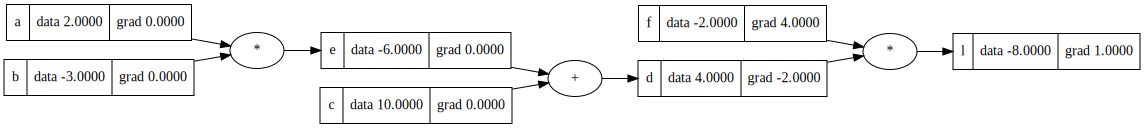

In [15]:
# We know that as per the equation, l = d * f

# hence, Derivative of l wrt d
# dl/dd = f
# and, derivative of l wrt f
# dl/df = d

# Lets calculate the gradient for d and f
d.grad = f.data
f.grad = d.data

# Redraw the graph
draw_dot(l)

#### STEP 3

Derive the gradient for c

        => dl/dc = dl/dd * dd/dc (using the chain rule)

We know value of dl/dd from step 2 already. We can calculate the derivative dd/dc as

        => d = c + e
        => dd/dc = 1

Hence,  

        => dl/dc = dl/dd * 1 = dl/dd    ---- (1)

Similarly, gradient for e can be calculated as

        => dl/de = dl/dd * dd/de

We know the value of dl/dd from step 2. The rest can be calculated as

        => d = c + e
        => dd/de = 1

Hence,

        => dl/de = dl/dd * 1 = dl/dd    ---- (2)


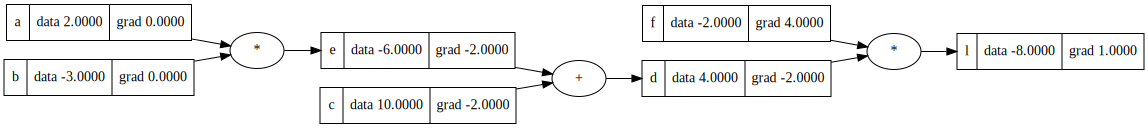

In [16]:
# Assigning gradients for c and e based on the calculation above
c.grad = d.grad
e.grad = d.grad

# Rebuilding the graph
draw_dot(l)

#### STEP 4

Apply chain rule once more in order to calculate a.grad and b.grad. We want to calculate dl/db and it can be represented as

        => dl/db = dl/de * de/db (using chain rule)
        
We know the values of dl/de (step 3) already. To get de/db, we know

        => e = a * b
        => de/db = a

Hence, we can say that
        
        => dl/db = e.grad * a ---- (3)


Similarly, we can get dl/da as

        => dl/da = dl/de * de/da (using chain rule)

We know the values of dl/de (step 3) already. To get de/da, we know

        => e = a * b
        => de/da = b

Hence, we can say that
        
        => dl/da = e.grad * b ---- (4)

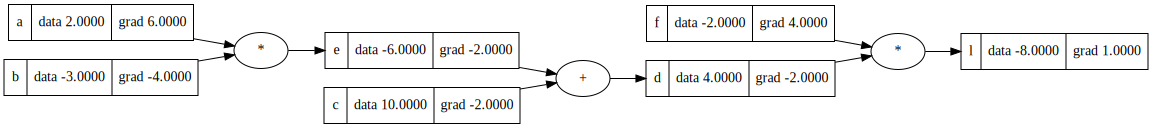

In [17]:
# Gradients for b and a can be calculated as follows
b.grad = e.grad * a.data
a.grad = e.grad * b.data

# Redrawing the graph
draw_dot(l)

Thats pretty much how the backpropagation works. Once the gradient value is set, the values of a, b can be altered slighlty and pass through forward propagation, such that the value of l (loss) is minimized. Then the backpropagation can be done again to calculate new gradients. This process can repeat until the loss can be reach close to 0.



## Implementing neural network with more complex nodes

Let us now take 2 input nodes x1 and x2, with weights and bias values. The output can be calculated as

        Sigma(xi * wi) + bias => activation function => Output


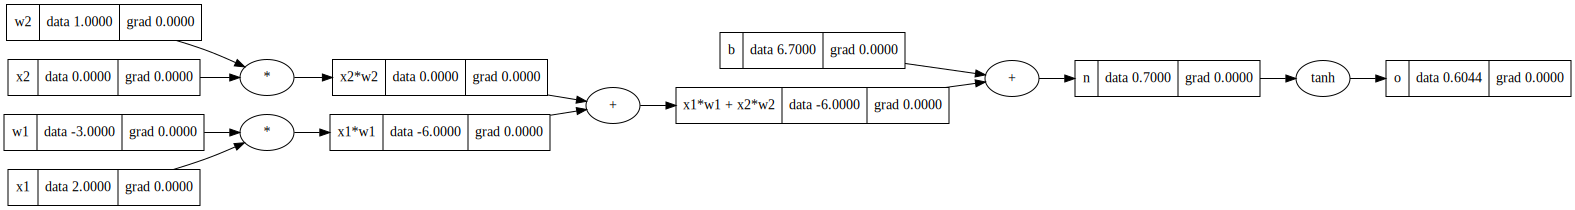

In [18]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

# pass the output of the neuron through the activation (tanh) function
o = n.tanh()
o.label = 'o'

# Draw the graph
draw_dot(o)

#### STEP 1

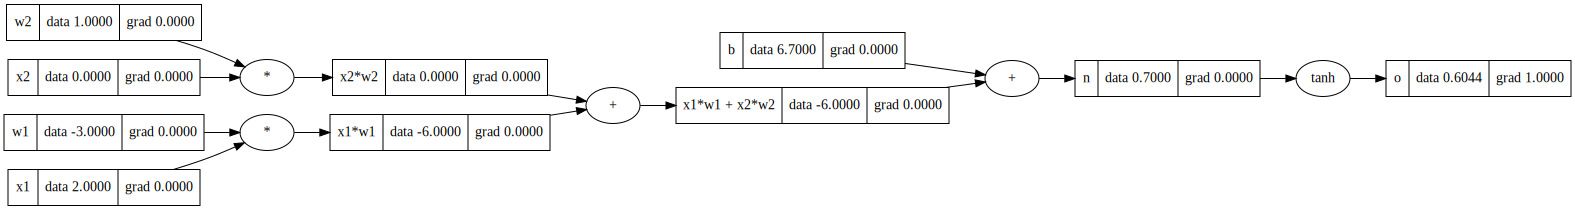

In [19]:
# Calculating the gradients for the output of the neuron
o.grad = 1.0

draw_dot(o)

#### STEP 2

We need to calculate do/dn next.

We can directly use the formula

        do/dn = 1 - tanh(n)**2

We already have the tanh function defined

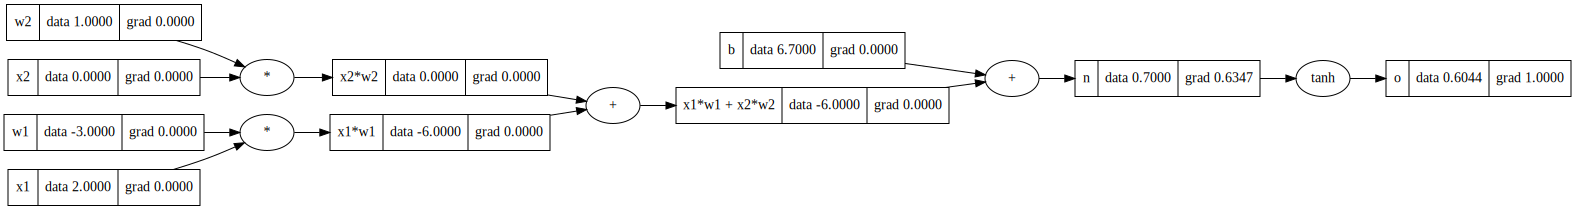

In [20]:
# Calculating the gradients for the neuron n
n.grad = 1 - o.data**2

draw_dot(o)

#### STEP 3

The next step is do/db and do/d(x1*w1 + x2*w2).

        => do/db = do/dn * dn/db
        => do/db = n.grad * dn/db
We know that
        => n = b + (x1*w1 + x2*w2)
        => dn/db = 1
hence,
        => do/db = n.grad * 1

Similarly, we can also get the value of do/d(x1*w1 + x2*w2) as

        => do/d(x1*w1 + x2*w2) = n.grad

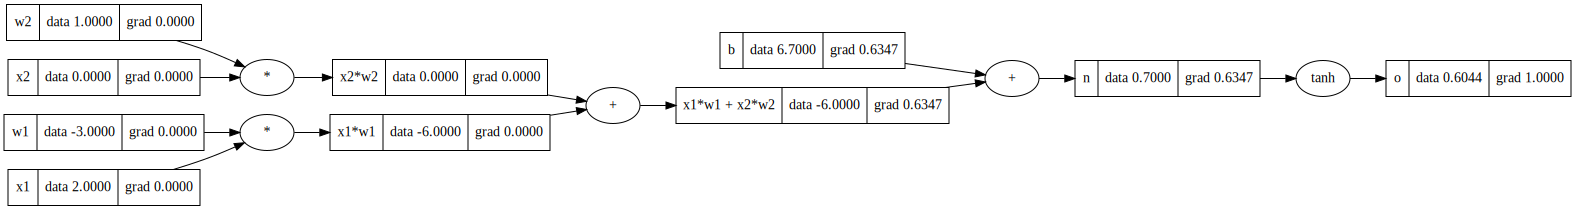

In [21]:
# Getting the gradients for the bias and weights
b.grad = n.grad
x1w1x2w2.grad = n.grad

#  Draw the graph
draw_dot(o)

#### STEP 4

Since it is a + sign again, we can follow the same pattern again and get that do/d(x2w2) and do/d(x1w1) are also n.grad

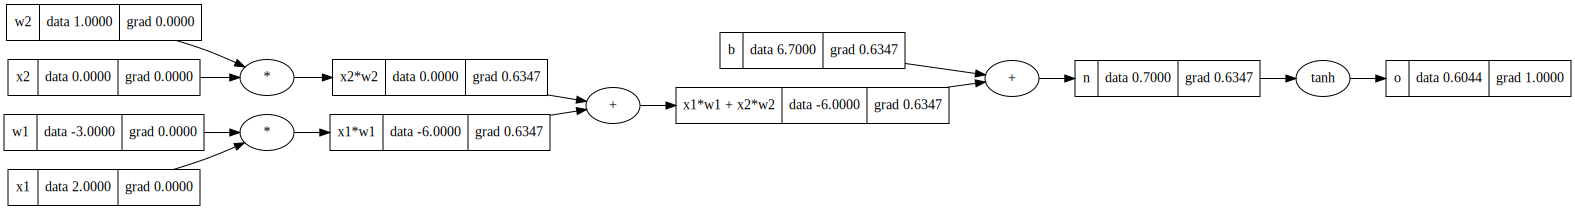

In [22]:
# Getting the gradients for the inputs
x1w1.grad = n.grad # Same as do/dx1w1
x2w2.grad = n.grad # Same as do/dx2w2

# Redrawing the graph
draw_dot(o)

#### STEP 5

This is the last step in this cycle. We need to calculate do/dx2 and do/dw1, and do/dx1 and do/dw1

        => do/dx2 = do/(x2w2) * d(x2w2)/dx2
        => do/dx2 = x2w2.grad * d(x2w2)/dx2

We also know that
        => x2w2 = x2 * w2
        => d(x2w2)/dx2 = w2

Hence, the overall value becomes

        => do/dx2 = x2w2.grad * w2 ---- (1)

Similarly, we can get the other 3 values as

        => do/dw2 = x2w2.grad * x2 ---- (2)

        => do/dx1 = x1w1.grad * w1 ---- (3)

        => do/dw1 = x1w1.grad * x2 ---- (4)


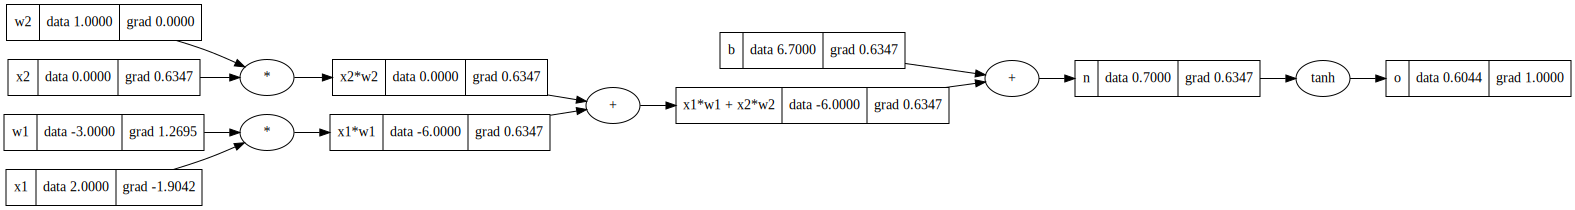

In [23]:
# Calculating the gradients for the inputs and weights
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

# Redrawing the graph
draw_dot(o)

Looking at the gradients for the input nodes, we can make the following observations:

- w2 has no influence on the output (derivative = 0)
- x2 and w1 will positively influence the output (derivative is +ve)
- x1 will negatively influence the output (derivative is -ve)

## PART B: Implementing the backpropagation in an automated manner

We can alter the class 'Value' to automate the calculation of backpropagation.

In [24]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # By default, we will assume that the gradient is 0
        self._backward = lambda: None # Initialize the backward function as None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
            other.grad = 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
            other.grad = self.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # Based on the derivative calculated earlier for tanh + applying chain rule
        out._backward = _backward

        return out


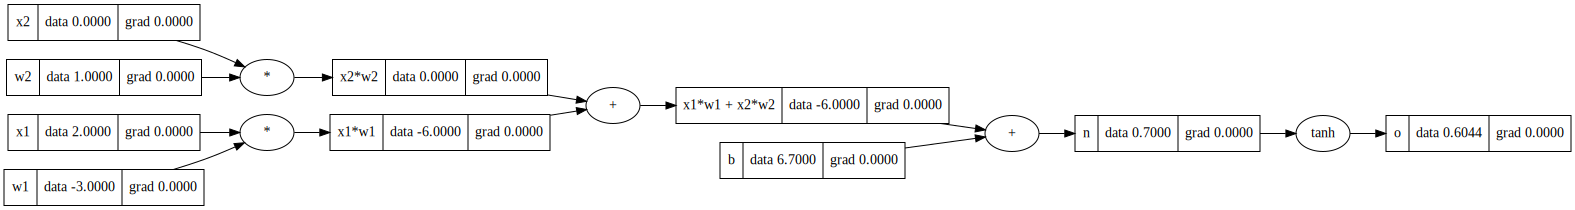

In [25]:
# Next, we will be resetting the variables and drawing the graph
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

# pass the output of the neuron through the activation (tanh) function
o = n.tanh()
o.label = 'o'

# Draw the graph
draw_dot(o)

This time, we do not need to call the individual steps. Instead, we can just call the ._backwards function in the required order

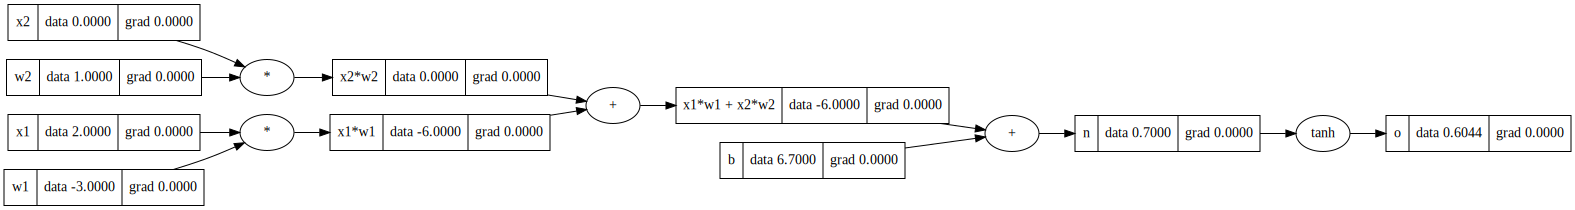

In [26]:
o._backward()

# Draw the graph
draw_dot(o)

The reason n.grad = 0 is because we have initialised the class value with self.grad = 0 i.e. o.grad = 0 in the first pass. When this passes through the tanh backward function, it returns 0. In order to handle this particular situation, we will initialise the o.grad = 1

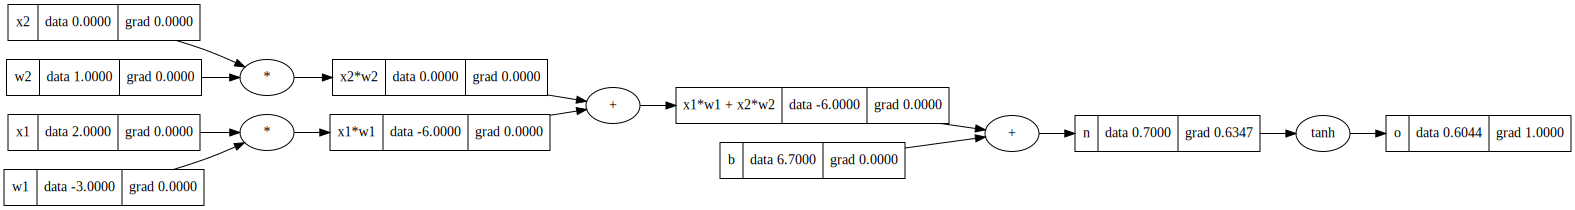

In [27]:
o.grad = 1.0 # Initialize the gradient of the output to 1

# Call the backward function from Value class. This will call the backward function from the tanh function
o._backward()

# Draw the graph
draw_dot(o)

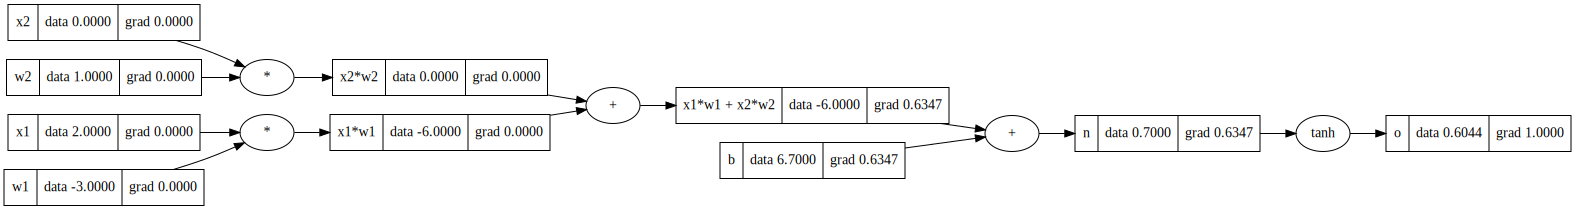

In [28]:
# Call the backward function from Value class. This will call the backward function from the addition function
n._backward()

# Draw the graph
draw_dot(o)

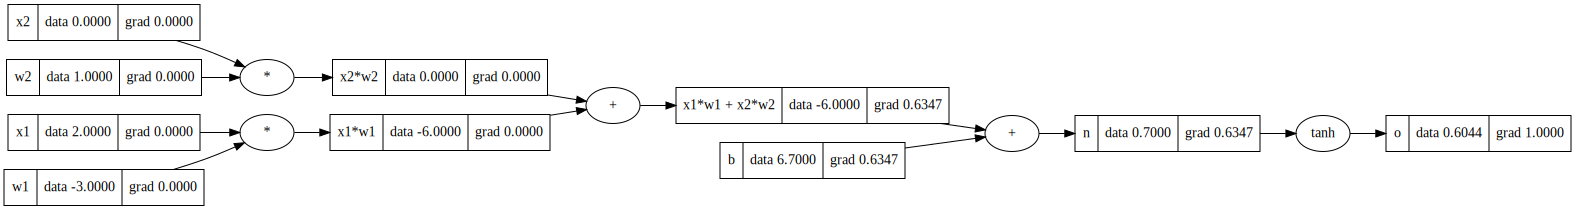

In [29]:
# Call the backward function from Value class. This will not lead to any output since its a leaf node
b._backward()

# Draw the graph
draw_dot(o)

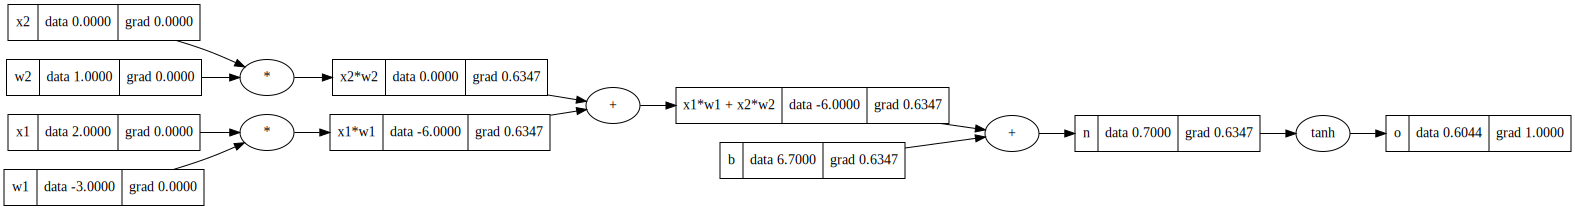

In [30]:
# Call the backward function from Value class. This will call the backward function from the addition function
x1w1x2w2._backward()

# Draw the graph
draw_dot(o)

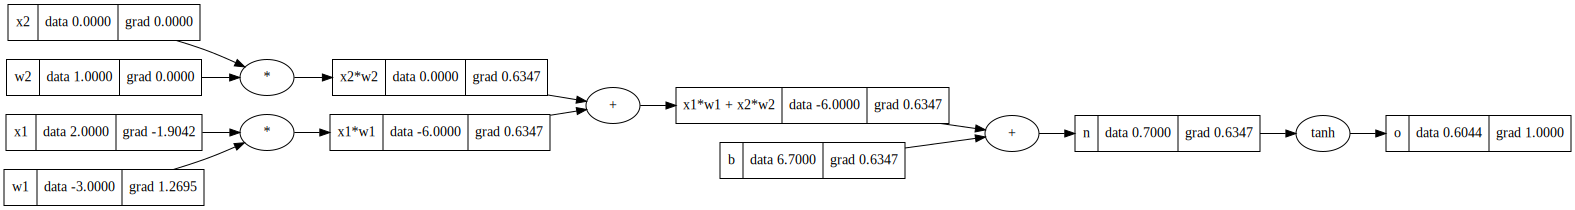

In [31]:
# Call the backward function from Value class. This will call the backward function from the multiplication function
x1w1._backward()

# Draw the graph
draw_dot(o)

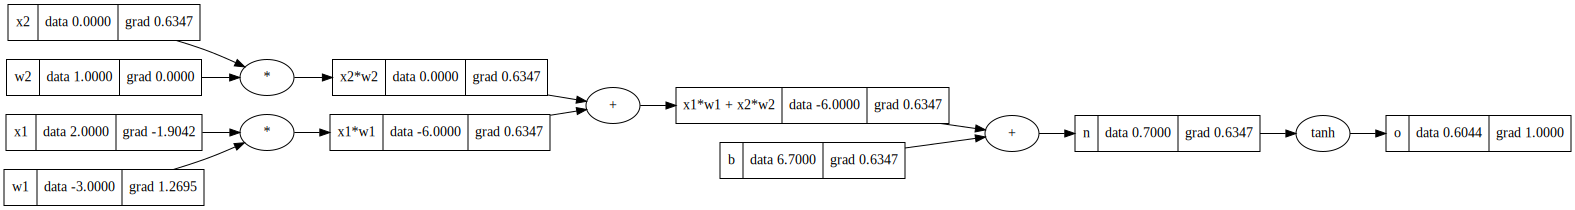

In [32]:
# Call the backward function from Value class. This will call the backward function from the multiplication function
x2w2._backward()

# Draw the graph
draw_dot(o)

## PART C: LOOPING THROUGH BACKWARD FUNCTION AUTOMATICALLY

One part that needs to be done and that is to avoid calling '.backward' manually. Essentially, what we want to do is that for the backward function get called for a node, gradients for the nodes on the right of it need to get resolved. In order to do that, we will implement a topological sort algorithm. This algorithm lays out the nodes such as all edges always only go from left to right.

![image.png](attachment:image.png)

In [33]:
# NOTE : This is just a sample code to demonstrate how to implement topological sort. This has been implemented in the Value class later and is not actually needed in the execution
# Implementing topological sort
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)

# Call the function of the output node
topological_sort(o)
topo

[Value(data=6.7),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

We can implement the topological sort and the backward function on a given node in the class itself. Once the topologicla sort is implemented, then we can call the backward function on each node of the topo list in reverse order (from output to input). This way, we can iteratively call the backward function and set the gradient for each of the nodes

In [34]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # By default, we will assume that the gradient is 0
        self._backward = lambda: None # Initialize the backward function as None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
            other.grad = 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
            other.grad = self.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # Based on the derivative calculated earlier for tanh + applying chain rule
        out._backward = _backward

        return out

    # Create a backward function that will do a topological sort of the graph and then call the _backward function of each node
    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)

        # Call the sort function on a node
        topological_sort(self)

        self.grad = 1.0 # Initialize the gradient of the output to 1

        # Iterate through the nodes in the reverse order (of topological sort) to implement the _backward function
        for node in reversed(topo):
            node._backward()



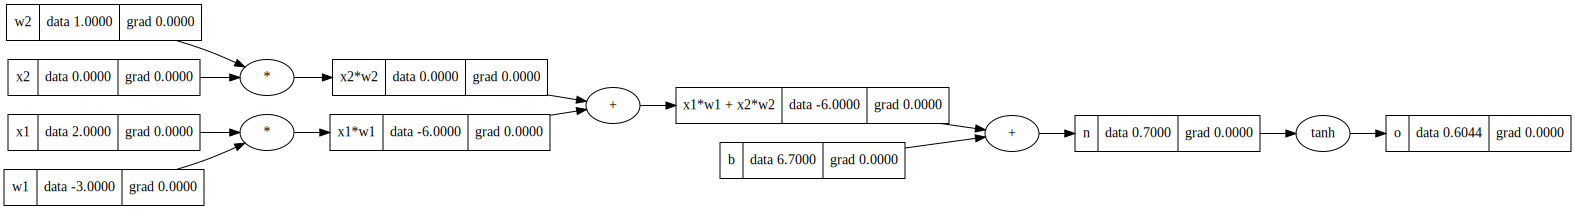

In [35]:
# Next, we will be resetting the variables and drawing the graph
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

# pass the output of the neuron through the activation (tanh) function
o = n.tanh()
o.label = 'o'

# Draw the graph
draw_dot(o)

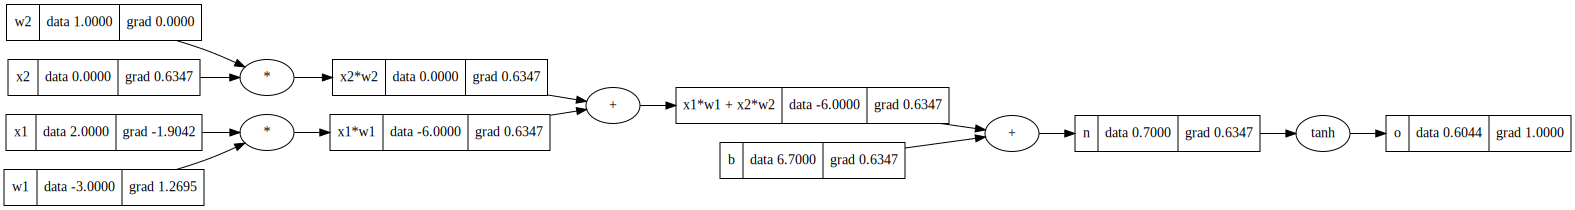

In [36]:
# Call the backward function on the output node
o.backward()

# Redraw the graph
draw_dot(o)

## PART D: HANDLING CASE WHERE VARIABLE IS USED MORE THAN ONCE

There is an issue in the implementation above where a variable is used more than once. The gradient (for 'other' in the class) overrides the initial value set (by 'self') and hence we always get the incorrect value. It didnt show up till now becase no variable was used more than once.

An example snippet is given below where you can see that the gradient of a (a.grad) is incorrect. it should have been 2 (if you take derivative) but it is giving 1.0
![image.png](attachment:image.png)

To handle this case, we just need to add the gradients (which is the case for multivariable use). In the class itself, we can change

        self.grad = 1.0 * out.grad    "TO"   self.grad += 1.0 * out.grad AND
        other.grad = 1.0 * out.grad     "TO"   other.grad += 1.0 * out.grad

This will work since the class has been initialised with the grad value set to 0. After making the changes, the gradient will show correctly

![image.png](attachment:image-2.png)

In [37]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # By default, we will assume that the gradient is 0
        self._backward = lambda: None # Initialize the backward function as None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
            other.grad += 1.0 * out.grad # Based on the derivative calculated earlier for addition function + applying chain rule
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
            other.grad += self.data * out.grad # Based on the derivative calculated earlier for multiplication function + applying chain rule
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # Based on the derivative calculated earlier for tanh + applying chain rule
        out._backward = _backward

        return out

    # Create a backward function that will do a topological sort of the graph and then call the _backward function of each node
    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)

        # Call the sort function on a node
        topological_sort(self)

        self.grad = 1.0 # Initialize the gradient of the output to 1

        # Iterate through the nodes in the reverse order (of topological sort) to implement the _backward function
        for node in reversed(topo):
            node._backward()




## PART E: TENSOR IMPLEMENTATION OF THE FUNCTION

In [38]:
import torch

In [39]:
# Cast the variables as double since python used double precision by default. Tensor has single precision and needs to be cast as double
# Also set require gradient = True. By default it is set to False for performance reasons
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.7]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


In [40]:

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.6043676560501806
----
x1 -1.9042192089612318
w1 1.2694794726408212
x2 0.6347397363204106
w2 0.0


## PART F: CREATE NEURAL NETWORK WITH PYTORCH - SINGLE NEURON


In [41]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):

        # Loop through each weight and input and multiply them and add bias to get activation function input
        act = self.b # Implementing w * x + b (next 2 lines included)
        for wi, xi in zip(self.w, x):
            act += wi * xi

        # Activation function
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b] # Returns a single list of weights and bias for a neuron


# Class to create a layer of neurons, given the number of inputs (nin) and ouput (nout) neurons in the layer
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters() # Get weights and biases in a single list for a neuron from Neuron class
            params.extend(ps)
        return params


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters() # Get the weight and biases for all neurons in each of the layers
            params.extend(ps)
        return params


# Adding more elements to the value class and refining the functions
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # Based on the derivative calculated earlier for tanh + applying chain rule
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [42]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4934090050160794, grad=0)

Lets take a simple example of a bianry classifier with 4 inputs and 4 binary outputs.

In [43]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, 2.0, 3.0],
    [0.0, 1.0, 2.0],
    [1.0, 2.0, 3.0]
]
ys = [1.0, -1.0, 1.0, -1.0] # desired outputs

In [44]:
# First forward pass without any optimization
ypred = [n(x) for x in xs]

# We can measure the performance of the model by calculating the mean squared error loss
loss = sum([(y_true - y_pred)**2 for y_true, y_pred in zip(ys, ypred)])
print('Loss in the 1st forward pass' ,loss)

# We can do a backward pass to calculate the gradients of the loss with respect to the weights and biases
loss.backward()

Loss in the 1st forward pass Value(data=5.770193340055226, grad=0)


In [45]:
# Print the total number of parameters in the neural network
print('Total number of parameters: ',len(n.parameters()))

# We want to now change the value of the parameters to reduce the loss
for p in n.parameters():
    p.data -= 0.01 * p.grad # Gradient descent

Total number of parameters:  41


In [46]:
# Forward pass after updating the weight and biases
ypred = [n(x) for x in xs]

# We can measure the performance of the model by calculating the mean squared error loss
loss = sum([(y_true - y_pred)**2 for y_true, y_pred in zip(ys, ypred)])
print('Loss in the 1st forward pass' ,loss)

# We can do a backward pass to calculate the gradients of the loss with respect to the new weights and biases. Expectation is to see a decrease in the loss
loss.backward()

Loss in the 1st forward pass Value(data=5.439720878730533, grad=0)


Essentially, we can keep on changing the parameters and calculate the loss function

## PART G: AUTOMATING THE FORWARD AND BACKWARD PASSES UNTIL IT REACHES LOWEST/DESIRED LOSS


In [47]:
for k in range(1000):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(y_true - y_pred)**2 for y_true, y_pred in zip(ys, ypred)])

    # Set all gradients to zero. This is important because the gradients are accumulated in the backward pass (we have used += in the backward pass to calculate the gradients)
    for p in n.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Update the weights and biases
    for p in n.parameters():
        p.data -= 0.05 * p.grad # Using 0.05

    print(k, loss.data)

0 5.439720878730533
1 4.007201910048851
2 3.7493207288974535
3 3.5876117771589797
4 3.4474276046976486
5 3.31631218334326
6 3.193377705644055
7 3.0810788154236946
8 2.981737980649382
9 2.895639053420206
10 2.8210190340722505
11 2.7548663931529696
12 2.693720069351761
13 2.6339956648965583
14 2.5718714037171653
15 2.5028092305049316
16 2.4206540583974125
17 2.316025330484013
18 2.173590608583849
19 1.9692727783425052
20 1.6784019249767077
21 1.3230005578230835
22 1.0016671084487792
23 0.771350873150281
24 0.612558096519465
25 0.4999496834992577
26 0.41734049807454865
27 0.35497192218713614
28 0.30669716461369956
29 0.2685425614961845
30 0.23783079934081433
31 0.2127126334852532
32 0.19187734457333705
33 0.1743768542243882
34 0.1595124471256164
35 0.14676043672266514
36 0.13572225495900064
37 0.12609025783810146
38 0.11762389507658227
39 0.11013282983081386
40 0.10346480125815792
41 0.09749677421882855
42 0.09212840085804533
43 0.08727713068988828
44 0.08287451147514163
45 0.078863360809

In [48]:
# Print the predicted outputs based on the updated weights and biases
ypred

[Value(data=0.9944233637522049, grad=-0.011153272495590283),
 Value(data=-0.9825379180012995, grad=0.03492416399740095),
 Value(data=0.9751552082311649, grad=-0.04968958353767028),
 Value(data=-0.9825379180012995, grad=0.03492416399740095)]